In [177]:
import quspin as qs
import numpy as np
import matplotlib.pyplot as plt
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d # Hilbert space spin basis
from quspin.operators import quantum_operator
import math
from quspin.basis import spin_basis_general
from matplotlib import colors
import random

In [179]:
def intmatrix(Lx, J, xs=1, ys=1, theta=0, phi=0, Ly='_', plot=False):
    # define side length of simulated system as L
    if Lx % 2 == 1:
        pass
    else:
        Lx += 1

    if Ly == '_':
        Ly = Lx
    else:
        if Ly % 2 == 1:
            pass
        else:
            Ly += 1
    
    mat = np.zeros((Lx, Ly))
    
    L_xrange, L_yrange = range(Lx), range(Ly)
    center_xindex = int(L_xrange[-1]/2)
    center_yindex = int(L_yrange[-1]/2)
    
    
    center = np.array([xs*center_xindex, ys*center_yindex, 0]) #position of matrix center (in 3D)
    
    quan_axis = [np.cos(theta)*np.sin(phi), np.sin(theta)*np.sin(phi), np.cos(phi)] #quantization axis as an unit vector
    
    
    for i in L_xrange:
        for j in L_yrange:
            displacement = np.array([xs*i, ys*j, 0]) - center
            r = np.linalg.norm(displacement)
            angle = np.arccos(displacement @ quan_axis/r)
            mat[i, j] = J*(1-3*(np.cos(angle)**2))/(r**3)
    mat[center_xindex, center_yindex] = 0.0

    if plot == True:
        fig, ax = plt.subplots()

        mat, xside, yside = intmatrix(Lx, J, Ly=Ly, theta=theta, phi=phi)
        couplings = np.transpose(mat) #transpose to show x and y axis correctly (this will also switch x and y corrdinate ordering when indexing)

        cmap = plt.cm.RdBu
        ax.matshow(couplings, cmap=cmap, norm=colors.CenteredNorm())

        for i in range(len(couplings)):
            for j in range(len(couplings[0])): 
                c = '{:g}'.format(float('{:.2g}'.format(couplings[i, j])))
                #c = '(' + str(j) + ', ' + str(i) + ')'
                    
                ax.text(j, i, str(c), va='center', ha='center')
    
    return mat, Lx, Ly #indexing interaction matrix is done with mat[x coordinate, y coordinate]

def ran_occupied_sites(N, x, y): #dimensions of simulated lattice and no of particles to distribute
    total_sites = int(x*y)

    # Randomize which lattice sites are occupied
    occupied_sites = []
    free_sites = list(range(total_sites))
    
    for i in range(N):
        ran = random.randint(0, total_sites-i-1)
        #print('random int = ' + str(ran))
        occupied_sites.append(free_sites.pop(ran))
        
    return sorted(occupied_sites) #returns ordered list of N unique numbers between 0 and the total sites - 1 inclusive

def couples(sites, pairs, interactions, xy='_'):
    if xy == '_':    
        int_x, int_y = len(interactions)//2 + 1, len(interactions[0])//2 + 1 #dimensions of interaction matrix
    else:
        int_x, int_y = xy
    #use interaction matrix to get couplings between each occupied site and output this in the correct formatt with particle number
    couples = []
    for i in pairs:
        p1, p2 = sites[i[0]], sites[i[1]]
        
        couples.append([interactions[int_x - 1  + (p1 % int_x) - (p2 % int_x), int_y - 1 + (p1 // int_x) - (p2 // int_x)], i[0], i[1]]) 
    return couples

def symm_mat(x, y, occupied_sites, basis, axis=1): #defult finds mirror plane transformation which flips x coordinates
    #only relevent if lattice simulated has the symmetry which is tested on basis staes
    #occupied sites labelled left to right up to down in basis
    #for rectangular simulated systems (but sites occupied can be picked)

    symm = np.zeros((len(basis), len(basis)))
    count1 = 0
    asymmetrics = []
    flips = []
    for i in basis:
        basis_on_lattice = np.zeros((x, y))
        count2 = 0
        for n in i:
            if n == 1:
                basis_on_lattice[occupied_sites[count2] % x, occupied_sites[count2] // x] = 1

            count2 += 1

        flipped = np.flip(basis_on_lattice, axis)
        
        
        if flipped == basis_on_lattice:
            symm[count1, count1] = 1
        else:
            asymmetrics.append(basis_on_lattice)
            flips.append(flipped)
        count1 += 1

    for state in asymmetrics:
        pair = np.where(flips == state)[0]
        symm[pair[0], pair[1]], symm[pair[1], pair[0]] = 1, 1

    return symm

/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_52690/1569909422.py:32: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)


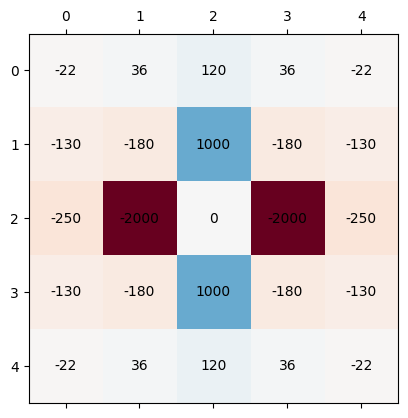

In [181]:
fig, ax = plt.subplots()

Lx, Ly, J = 5, 5, 1000
theta, phi = 0, 2*np.pi/4

mat, xside, yside = intmatrix(Lx, J, Ly=Ly, theta=theta, phi=phi)
couplings = np.transpose(mat)

cmap = plt.cm.RdBu
ax.matshow(couplings, cmap=cmap, norm=colors.CenteredNorm())

for i in range(len(couplings)):
    for j in range(len(couplings[0])):
        c = '{:g}'.format(float('{:.2g}'.format(couplings[i, j])))
        ax.text(j, i, str(c), va='center', ha='center')

In [183]:
def str_tens(A, B):
    new = []
    for i in A:
        for n in B:
            new.append(i + n)
    return new

def up_pop_plot(L, populations, values, dep_var):
    #basis = [r'0', r'1']
    #labels = [r'0', r'1']
    #for i in range(L - 1):
        #labels = str_tens(labels, basis)
    n_rows = len(populations[0])
    n_cols = len(populations[0][0])
    probs = [[matrix[i][j] for matrix in populations] for i in range(n_rows) for j in range(n_cols)]
    values = values*(10**3)    
    fig, axes = plt.subplots(1, 1)
    for i in range(L):
        axes.plot(values, probs[i], label=f'Particle {i+1}')
        
    #for i in range(5):
        #print(populations[:,1][100*i])

    axes.set_ylabel(r"Probability of detecting $\left|1\right>$", fontsize=20)
    axes.set_xlabel(dep_var, fontsize=20)
    axes.legend(loc=1, prop={'size': 14})

    axes.minorticks_on()
    axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
    axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
    axes.set_yticks([0, 0.5, 1]) 
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.savefig(f'{L}_Particle_Empty_site.png', bbox_inches='tight')
    
    plt.show(block=False)

In [185]:
#define pulse sequences
def pulse_ramsey(t, pulse_time, free_time, rabi_frequency):
    if t <= pulse_time:
        return rabi_frequency
    elif t < pulse_time + free_time:
        return 0 
    elif t <= 2 * pulse_time + free_time:
        return rabi_frequency
    else:
        return 0

def pulse_single(t, pulse_time, free_time, rabi_frequency):
    if t <= pulse_time:
        return rabi_frequency
    else:
        return 0

def no_pulse(t, pulse_time, free_time, rabi_frequency):
    return 0

In [187]:
pulse_time = 0.0478e-3 # in s
free_time = 15000 * pulse_time # 0.6e-3 # in s
rabi_frequency = 2*np.pi*(1/pulse_time)/4 # From RbCs Ramsey Paper https://doi.org/10.1088/2058-9565/aaee35 Figure 7
print((pulse_time*rabi_frequency)/(np.pi/2)) # Check pulse time and rabi frequency give a pi/2 pulse area 

0.9999999999999999


Hermiticity check passed!
Symmetry checks passed!
[[  0.+0.j   0.+0.j   0.+0.j ...   0.+0.j   0.+0.j   0.+0.j]
 [  0.+0.j   0.+0.j 125.+0.j ...   0.+0.j   0.+0.j   0.+0.j]
 [  0.+0.j 125.+0.j   0.+0.j ...   0.+0.j   0.+0.j   0.+0.j]
 ...
 [  0.+0.j   0.+0.j   0.+0.j ...   0.+0.j 125.+0.j   0.+0.j]
 [  0.+0.j   0.+0.j   0.+0.j ... 125.+0.j   0.+0.j   0.+0.j]
 [  0.+0.j   0.+0.j   0.+0.j ...   0.+0.j   0.+0.j   0.+0.j]]


/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_52690/1569909422.py:32: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)


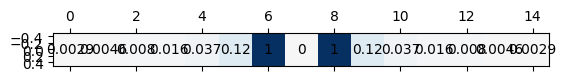

In [189]:
L = 5

J = 1000 #Hz
det = 0 #detuning
ax, ay = 2, 1 #lattice seperation in x and y directions  AX MAY BE SET AS AN AXIS LATER RATHER THAN THIS VALUE
row_len, Ly = 8, 1 #Number of sites per row in lattice, NOTE row_len = Lx
theta, phi = 0, 0 #define quantization axis

filled_sites = [0, 1, 3, 4, 6]

if len(filled_sites) != L:
    print('Invalid Filled Sites')
    
params = [pulse_time, free_time, rabi_frequency]

def construct_H(N, J, det, ax, ay, Lx, params, pulse, theta=0, phi=0, Ly='_', int_plot=False, occupied_sites='_'):
    basis = spin_basis_general(N=N, pauli=False)
    #print(basis)
    if Ly == '_':
        Ly = 1

    #construct interaction
    sites = range(N)
    pairs = [[i, k] for idx, i in enumerate(sites) for k in sites[idx + 1:]]
    
    #interaction strengths between each particle
    interaction_matrix, _, _ = intmatrix(Lx*2 - 1, 1, xs=ax, ys=ay, theta=theta, phi=phi, Ly=Ly*2 - 1, plot=int_plot) 
    #above outputs 3 variables (also set J=1 in this function as it xJ at the end anyway) 

    #determin sites that are occupied (random or not)
    if occupied_sites == '_':
        sites = ran_occupied_sites(N, Lx, Ly)
    else:
        sites = sorted(occupied_sites) #make sure occupied sites is the correct length with numbers under total sites

    #contruct infomation in to reqired format
    intr = couples(sites, pairs, interaction_matrix)
    
    #construct resonant and detuning terms
    drive = [[1.0, i] for i in range(N)]
    detuning = [[1.0, i] for i in range(N)]

    operator_list_0 = [['z', detuning]]
    operator_list_1 = [['x', drive]]

    #print(intr)

    #construct full Hamiltonian
    interaction = [['+-', intr], ['-+', intr]]
    operator_dict = {'detuning': operator_list_0, 'drive': operator_list_1, 'interaction': interaction}
    H = quantum_operator(operator_dict, basis=basis)
    params_dict = dict(detuning=det, drive=(pulse, params), interaction=J)
    H_lmbda1 = H.tohamiltonian(params_dict)
    return H_lmbda1

H_lmb0 = construct_H(L, J, det, ax, ay, row_len, params, no_pulse, Ly=Ly, theta=theta, phi=phi, int_plot=True, occupied_sites=filled_sites) #note if the occupied sites are specified

print(np.array2string(H_lmb0.toarray(), suppress_small=True, formatter={'float': '{:0.4f}'.format}))


In [191]:
def sparse_up_prob(L, row_len, col_len, populations):
    basis = spin_basis_general(N=L, pauli=False)
    #col_len = int(math.ceil(L/row_len))

    #contruct outer product of single particle up spin state operator to find the probability it is in up
    outer_products = []
    for i in range(L):
        factors = [[[0.5, i]], [[-1, i]]]
        opers = [['I', factors[0]], ['z', factors[1]]]
        input_dict = {'up': opers}
        outer_products.append(quantum_operator(input_dict, basis=basis))
        #__ = quantum_operator(input_dict, basis=basis).tohamiltonian()
        #print(__.toarray())


    #calculate the probability each particle is spin up for each time evolved
    results = []
    for i in np.transpose(populations):
        probs = []
        for n in range(L):
            probs.append(outer_products[n].expt_value(i))
        results.append(sum(probs)/L)

    #print(results)
    return results

In [193]:
def ensemble_Ramsey(samples, time, p_max, r_max, initial_state, N, J, det, ax, ay, params, pulse, theta=0, phi=0):
    results = []
    for i in range(samples):
        r = random.randint(0, int(3000*r_max/4))/1000
        p = p_max*(1 - (r/r_max)**2)
        L = int(np.sqrt(N/p))+1
        print(L)
        Hamiltonian = construct_H(N, J, det, ax, ay, L, params, pulse, theta=theta, phi=phi, Ly=L)
        populations = H_lmb0.evolve(initial_state, 0, times)
        ups = sparse_up_prob(N, L, L, populations)
        results.append(ups[-1])
        print('Sample ' + str(i) + ' completed')
    return sum(results)/samples

In [203]:
intervals = 10
samples = 5
holds = np.linspace(0, 10, intervals)

particles_per_sample = 5
J, det, ax, ay = 1000, 0, 1, 1
p_max, r_max = 0.90, 1000
theta, phi = 0, 0

initial_state = np.zeros(2**particles_per_sample)
initial_state[0] = 1

up_probabilities = []
for i in holds:
    #time = [0, pulse_time, pulse_time + i, 2*pulse_time + i]
    time = np.linspace(0, 2*pulse_time + i, 1000)
    params = [pulse_time, i, rabi_frequency]
    up_probabilities.append(ensemble_Ramsey(samples, time, p_max, r_max, initial_state, particles_per_sample, J, det, ax, ay, params, pulse_ramsey, theta=theta, phi=phi))



3
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_52690/1569909422.py:32: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)


Sample 0 completed
3
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Sample 1 completed
3
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Sample 2 completed
4
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Sample 3 completed
3
Hermiticity chec

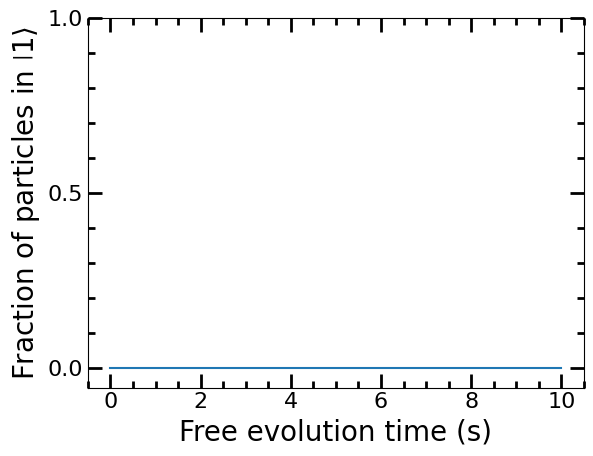

In [204]:
fig, axes = plt.subplots(1, 1)

axes.plot(holds, up_probabilities)
        
    #for i in range(5):
        #print(populations[:,1][100*i])

axes.set_ylabel(r"Fraction of particles in $\left|1\right>$", fontsize=20)
axes.set_xlabel('Free evolution time (s)', fontsize=20)

axes.minorticks_on()
axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
axes.set_yticks([0, 0.5, 1]) 
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.savefig(f'Ensemble_Ramsey.png', bbox_inches='tight')
    
plt.show(block=False)

In [109]:
#Computing eigenvalues and eigenvectors
eigen = False
if eigen == True:
    Js = np.linspace(-J, J, 100)
    energies = []
    for i in Js:
        H_i = construct_H(L, i, det, 1, 1, row_len, params, no_pulse, Ly=Ly)
        print(np.array2string(H_i.toarray(), suppress_small=True, formatter={'float': '{:0.4f}'.format}))
        val, vec = H_i.eigh()
        energies.append(val)
        evec = vec
    
    ket = [r'0', r'1']
    labels = [r'0', r'1']
    for i in range(L - 1):
        labels = str_tens(labels, ket)
    
    fullvec = []
    for i in vec:
        count = 0
        lab = ''
        for n in i:
            if n == 0:
                pass
            else:
                print(n)
                print(type('{:.2g}'.format(n)))
                lab = lab + ' +(' + '{:.2g}'.format(n) + ')|' + labels[count] + r'$\rangle$'
                
            count += 1
        fullvec.append(lab)
    print(fullvec)
    
    energy = [[matrix[i] for matrix in energies] for i in range(len(energies[0]))]
       
    fig, axes = plt.subplots(1, 1)
    for i in range(len(fullvec)):
        axes.plot(Js, energy[i], label=fullvec[i])
            
        #for i in range(5):
            #print(populations[:,1][100*i])
    
    axes.set_ylabel(r"Eigenvalue", fontsize=20)
    axes.set_xlabel('Interaction strength, J', fontsize=20)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 14})
    
    axes.minorticks_on()
    axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
    axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.savefig(f'{L}_Particle_Eigenvectors.png', bbox_inches='tight')
        
    plt.show(block=False)

In [111]:
#for labelling graphs
def str_tens(A, B):
    new = []
    for i in A:
        for n in B:
            new.append(i + n)
    return new

/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_52690/1569909422.py:32: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(displacement @ quan_axis/r)


Hermiticity check passed!
Symmetry checks passed!
(7.835524205906458e-07+0.0008851845822419208j)
Hermiticity check passed!
Symmetry checks passed!
(4.408874255065327e-08+0.00020997318983430685j)
Hermiticity check passed!
Symmetry checks passed!
(0.014361401118748363+0.11896408198938531j)
Hermiticity check passed!
Symmetry checks passed!
(6.912151750869587e-06+0.002629087973636044j)
Hermiticity check passed!
Symmetry checks passed!
(2.9965856551751202e-06+0.0017310622820569655j)
Hermiticity check passed!
Symmetry checks passed!
(9.59672422502751e-05+0.009795815652089613j)
Hermiticity check passed!
Symmetry checks passed!
(0.00013406020228401978+0.011577659138357312j)
Hermiticity check passed!
Symmetry checks passed!
(0.1245604080003601+0.33017886187752254j)
Hermiticity check passed!
Symmetry checks passed!
(0.0026097759616124875+0.051019174255381265j)
Hermiticity check passed!
Symmetry checks passed!
(0.19465344870698395+0.39587952026672896j)
Hermiticity check passed!
Symmetry checks pa

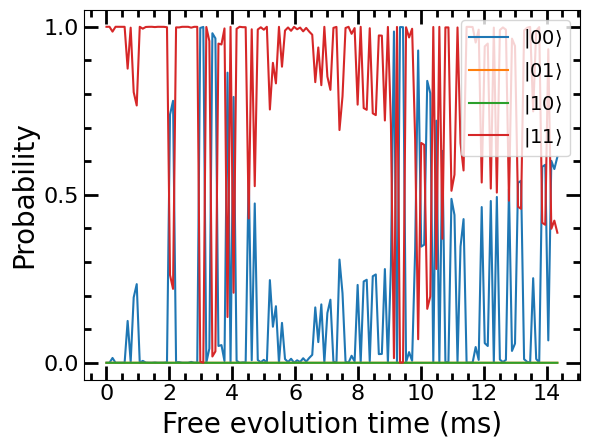

In [213]:
rams = True
if rams == True:
    intervals = 150
    holds = np.linspace(0, 300 * pulse_time, intervals)
    J = 1000
    L=2

    psi_0 = np.zeros(2**L)
    psi_0[0] = 1 
    probs = []
    for free_time in holds:
        params = [pulse_time, free_time, rabi_frequency]
        H_lmb = construct_H(L, J, 0, ax, ay, row_len, params, pulse_ramsey)
        times = np.linspace(0, 2*pulse_time + free_time, 1000)
        populations = H_lmb.evolve(psi_0, 0, times)
        print(populations[0][-1])
        probs.append([abs(populations[0][-1])**2, abs(populations[1][-1])**2, abs(populations[2][-1])**2, abs(populations[3][-1])**2])


    ket = [r'0', r'1']
    labels = [r'0', r'1']
    for i in range(L - 1):
        labels = str_tens(labels, ket)
    fig, axes = plt.subplots(1, 1)
    for i in range(2**L):
        axes.plot(holds*(10**3), [row[i] for row in probs], label='|' + labels[i] + r'$\rangle$')
        
        #for i in range(5):
            #print(populations[:,1][100*i])

    axes.set_ylabel(r"Probability", fontsize=20)
    axes.set_xlabel('Free evolution time (ms)', fontsize=20)
    axes.legend(loc=1, prop={'size': 14})

    axes.minorticks_on()
    axes.tick_params(which='major', length=10, width=2, direction='in', bottom=True, top=True, left=True, right=True)
    axes.tick_params(which='minor', length=5, width=2, direction='in', bottom=True, top=True, left=True, right=True)
    axes.set_yticks([0, 0.5, 1]) 
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.savefig(f'{L}_Particle_ramsey.png', bbox_inches='tight')
    
    plt.show(block=False)


In [115]:
intervals = 1000
times = np.linspace(0, 0.5, intervals)
psi_0 = np.zeros(2**L)
psi_0[12] = 1  
#psi_0[16] = 1  #only middle spin spin up

ket = [r'0', r'1']
labels = [r'0', r'1']
for i in range(L - 1):
    labels = str_tens(labels, ket)
    
populations = H_lmb0.evolve(psi_0, 0, times)
print(len(populations))

#fig, axes = plt.subplots(1, 1)
#for i in range(len(populations)):    
    #axes.plot(times, abs(populations[i])**2, label='|' + labels[i] + r'$\rangle$')
#plt.legend()
#plt.show

64


In [61]:
def up_prob(L, row_len, populations):
    basis = spin_basis_general(N=L, pauli=False)
    col_len = int(math.ceil(L/row_len))

    #contruct outer product of single particle up spin state operator to find the probability it is in up
    outer_products = []
    for i in range(L):
        factors = [[[0.5, i]], [[-1, i]]]
        opers = [['I', factors[0]], ['z', factors[1]]]
        input_dict = {'up': opers}
        outer_products.append(quantum_operator(input_dict, basis=basis))
        #__ = quantum_operator(input_dict, basis=basis).tohamiltonian()
        #print(__.toarray())


    #calculate the probability each particle is spin up for each time evolved
    results = []
    for i in np.transpose(populations):
        probs = np.zeros((col_len, row_len))
        for n in range(L):
            if n==4:
                print(outer_products[n].expt_value(i))
            probs[n//row_len][n%row_len] = outer_products[n].expt_value(i)
        results.append(probs)

    #print(results)
    return results

results = up_prob(L, row_len, populations)
    

Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
0j
(0.0038152705599633573+0j)
(0.010871391674075208+0j)
(0.013558879932640319+0j)
(0.01111954757596132+0j)
(0.011961231297612502+0j)
(0.024528304262071716+0j)
(0.046508118254096995+0j)
(0.06522051810833701+0j)
(0.07042527692495924+0j)
(0.06653014808140571+0j)
(0.07019313521376816+0j)
(0.09395556305650316+0j)
(0.13204252125784666+0j)
(0.16392462106392186+0j)
(0.1738535136923684+0j)
(0.1675119132047153+0j)
(0.1682102655655358+0j)
(0.1947763739769352+0j)
(0.2422293034709046+0j)
(0.2849189307179741+0j)
(0.3003661939825661+0j)
(0.29126314462345515+0j)
(0.2838491575481012+0j)
(0.3032972166210058+0j)
(0.3493352808360184+0j)
(0.3957417185566786+0j)
(0.41468823659265325+0j)
(0.40293816733548643+0j)
(

/var/folders/ln/c_qknrr51xbgxcyyp59605kr0000gn/T/ipykernel_52690/1076318461.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  probs[n//row_len][n%row_len] = outer_products[n].expt_value(i)


In [63]:
#plot result matricies
from mpl_toolkits.axes_grid1 import ImageGrid

if intervals <= 64:

    dims = int(math.ceil(np.sqrt(len(results))))

    fig = plt.figure(figsize=(1.5*dims, 1.5*dims))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(dims, dims),  # creates grid of Axes
                     axes_pad=0.3,  # pad between Axes in inch.
                     )

    count = 0
    for ax in grid:
        # Iterating over the grid returns the Axes.
        cax = ax.matshow(results[count])
        cax.set_clim(0, 1)
    
        # Hide X and Y axes label marks
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)

        # Hide X and Y axes tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('{:g}'.format(float('{:.3g}'.format(times[count]*(10**3)))) + 'ms')
        count += 1

    cbar = fig.colorbar(cax, location="right", 
            shrink=0.5,
            aspect=30,
            fraction=0.5,
            anchor=(1.1,0.5))

    cbar.ax.set_ylabel('Probability of detecting spin up state', fontsize=16)
    plt.savefig(f'{L}_particles_empty_site.pdf', bbox_inches='tight')
    plt.show()
else:
    pass




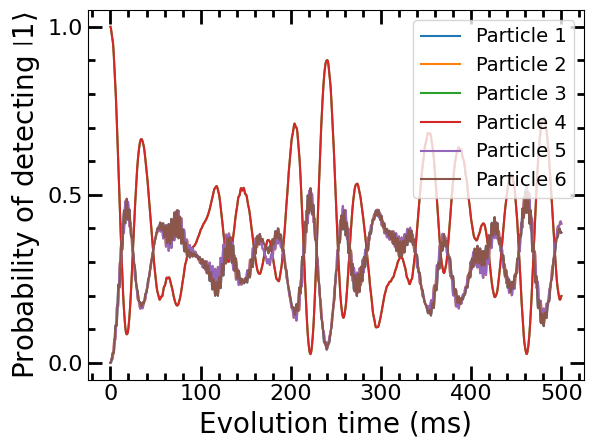

In [65]:
if intervals >= 100:
    up_pop_plot(L, results, times, 'Evolution time (ms)')

In [ ]:
# animation
from matplotlib.animation import PillowWriter

metadata = dict(title='Movie', artist='codinglikemad')
writer = PillowWriter(fps=24, metadata=metadata)

fig, ax = plt.subplots()

ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([])


cbar.ax.set_ylabel('Probability of detecting spin up state')

with writer.saving(fig, f'{L}_particle_2D_spin.gif', 100):
    cax = ax.matshow(results[0])
    cax.set_clim(0, 1)
    cbar = fig.colorbar(cax, location="right", 
            shrink=0.6,
            aspect=30,
            fraction=0.5)
    count = 0
    for i in results[0:]:
        ax.clear()
        ax.set_title('{:g}'.format(float('{:.3g}'.format(times[count]))) + 's')
        cax = ax.matshow(i)
        writer.grab_frame()
        count += 1
        
    